#14-1. 들어가며
지난 시간에는 bAbI 태스크의 특징 및 이런 추론 태스크 수행에 적합한 메모리 네트워크의 개념에 대해 알아보았습니다.

오늘은 메모리 네트워크의 가장 기본적 베이스라인으로 여겨지고 있는 End-to-End Memory Network를 구현해 보고, 이를 이용해서 bAbI 태스크를 직접 수행해 보도록 하겠습니다.

-------------------------

학습 목표

1. 두 개 이상의 입력을 받는 모델을 설계해본다.

2. 메모리 구조를 사용하는 메모리 네트워크에 대해서 이해한다.


# 14-2. 데이터 로드하기
bAbI 데이터셋을 로드해 보겠습니다. 우선 필요한 도구들을 임포트합니다.

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

tf.keras의 get_file()을 통해 파일을 다운로드합니다.



In [2]:
# 환경에 맞게 경로 수정
home_dir = '/content/drive/MyDrive/DL_Study/AIFFEL/GoingDeeper/GD_14_InferencingAI'
file_to_save = home_dir + '/babi-tasks-v1-2.tar.gz'
path = get_file(file_to_save, origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
print(path)

/content/drive/MyDrive/DL_Study/AIFFEL/GoingDeeper/GD_14_InferencingAI/babi-tasks-v1-2.tar.gz


압축 파일이기 때문에 압축을 풀어줄 필요가 있습니다.



In [3]:
with tarfile.open(path) as tar:
    tar.extractall(home_dir)  # ~/aiffel/babi_memory_net 아래에 압축해제
    tar.close()

훈련 데이터의 경로와 테스트 데이터의 경로를 지정해줍니다.



In [4]:
# 환경에 맞게 경로 적절히 수정
DATA_DIR = home_dir + '/tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [5]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


앞서 설명한 데이터셋의 형태를 따르는 것을 확인할 수 있습니다.

#14-3. 데이터 전처리 (1) 기본 전처리
이제 데이터 전처리를 진행합니다. 우선, 첫 번째 전처리는 데이터를 읽는 과정에서 스토리, 질문, 답변을 각각 분리해서 저장합니다. 그리고 이 과정에서 supporting fact(실제 정답이 몇번째 문장에 있었는지를 알려주는 인덱스 힌트정보)는 저장하지 않습니다.



In [6]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

read_data()를 통해 스토리, 질문, 답변의 쌍을 리턴하여 훈련 데이터는 train_data()에, 테스트 데이터는 test_data()에 저장합니다. 이 두 데이터를 가지고 추가적인 전처리를 진행할 예정입니다.



In [7]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

그런데 이렇게 저장하면 전처리가 정말 잘 되어있는지 확인하기 어렵겠죠? 그래서 스토리, 질문, 답변을 각각 저장하고 직접 출력해 보겠습니다.

In [ ]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

각각의 샘플 개수를 출력해 보겠습니다.



In [ ]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


훈련 데이터는 10,000개 테스트 데이터는 1,000개임을 볼 수 있습니다.

임의로 3,879번째 스토리를 출력해봅시다.



In [ ]:
train_stories[3878]

['Daniel journeyed to the bathroom.',
 'Sandra moved to the office.',
 'John went to the kitchen.',
 'Sandra moved to the bathroom.',
 'Daniel moved to the hallway.',
 'Mary travelled to the kitchen.',
 'Daniel went to the kitchen.',
 'Daniel travelled to the bathroom.']

상위 5개의 답변을 출력합니다.



In [ ]:
train_questions[:5]

['Where is Mary? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Sandra? ']

토큰화를 위한 함수를 만듭니다. 이 함수는 아래의 전처리 함수에서 호출할 예정입니다.

아래 함수는 사용하시는 파이썬 버전에 따라 다르게 주석을 해제해서 사용하시면 됩니다. [다음 이슈](https://github.com/keras-team/keras/issues/13248)를 참고하세요.

In [ ]:
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

이번 주요 전처리 작업은 단어장을 생성하고, 단어에서 정수로, 정수에서 단어로 맵핑하는 딕셔너리(dictionary)를 만드는 것입니다. 그리고 그 과정에서 스토리와 질문의 가장 긴 길이를 구하겠습니다. 이 길이는 패딩에 이용됩니다.

한 가지 특이한 과정이 있습니다. 위처럼 전처리를 하면서 같은 스토리 내의 여러 문장들 하나의 문장으로 통합할 겁니다. 가령, 앞서 3,879번째 스토리는 8개의 문장으로 구성되어 있으나 전처리 과정에서 8개의 문장을 모두 이어 붙여서 1개의 문장으로 통합합니다.

In [ ]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

이제 전처리 함수를 사용하여 단어장과 가장 긴 샘플의 길이를 리턴 받습니다.



In [ ]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

단어장을 출력해보겠습니다.



In [ ]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


실제 변수로 사용할 단어장의 크기는 패딩을 고려하여 +1 을 해주어야 합니다.



In [ ]:
vocab_size = len(word2idx) + 1


전처리 함수를 통해서 구한 스토리와 질문의 최대 길이를 각각 출력해 보겠습니다.



In [ ]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


스토리의 최대 길이는 68입니다. 이는 스토리 내에 있는 여러 개 문장들을 하나의 문장으로 간주하였을 때, 최대 단어의 개수라고 보면 됩니다. 질문의 최대 길이는 4입니다. bAbI 데이터셋에는 대체로 'Where is Mary?'와 같은 매우 짧은 길이의 질문들만 존재한다는 의미입니다.

#14-4. 데이터 전처리 (2) 패딩, 정수 인코딩, 벡터화

위에서 최대 길이를 구해놓은 이유는 패딩을 위함입니다.

이제 남은 전처리는 크게 세 가지입니다.

현재 각 데이터는 전부 텍스트 데이터입니다. 이를 단어와 맵핑되는 정수로 인코딩해줍니다. 이 과정은 앞서 만들어놓은 word2idx를 활용합니다.
스토리와 질문 데이터에 대해서 각각의 최대 길이로 패딩(padding)합니다. 이 과정은 앞서 계산해놓은 story_max_len과 question_max_len을 사용합니다.
레이블에 해당되는 정답 데이터를 원-핫 인코딩합니다.
아래의 vectorize() 함수는 위 세 가지 과정을 수행합니다.

In [ ]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

훈련 데이터와 테스트 데이터에 대해서 함수를 호출하여 이를 수행합니다.



In [ ]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

반환된 결과의 크기(shape)를 확인해 봅시다.



In [ ]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


#14-5. 메모리 네트워크 구현하기

모델 구현을 위한 도구들을 임포트합니다.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

우선 주요 하이퍼파라미터를 정의합니다.



In [ ]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

입력을 담아두는 변수들을 정의합니다.



In [ ]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


이제 본격적으로 메모리 네트워크 모델을 구현해 봅시다. 구현할 End-to-end Memory Network 모델의 구조는 이전 노드에서 이미 다룬 바 있습니다. 먼저 아래 그림과 같이 텍스트 입력을 임베딩으로 변환하는 인코더를 구현해 보겠습니다.

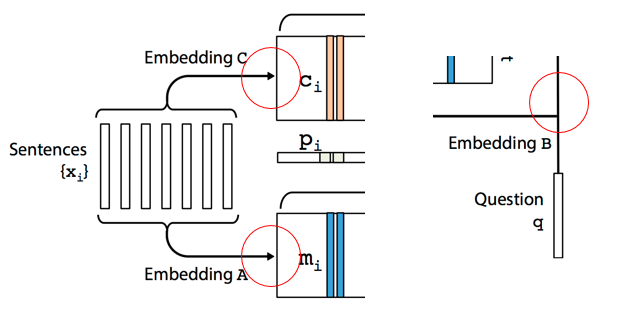

In [ ]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [ ]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

구현된 인코더를 이용해 텍스트를 임베딩으로 변환해 봅시다.



In [ ]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'") 



이제 구현해야 할 것은 스토리 문장과 질문 문장의 매칭 유사도 계산 과정입니다. 아래 그림은 이전 노드에서 보았던 soft attention 방식의 유사도 구하기를 표현한 것입니다.

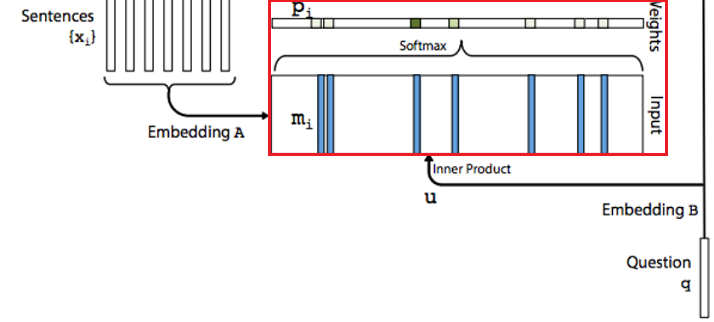

$$p = Softmax(dot(m,u))$$

In [ ]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


예측에 사용되는 출력 행렬은 매칭 유사도 match와 스토리 표현 input_encoded_c을 더해서 구하게 됩니다.



In [ ]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


이제 모델을 정의하고 훈련을 수행해 보겠습니다.



In [ ]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 19s 7ms/step - loss: 2.0012 - acc: 0.1684 - val_loss: 1.7543 - val_acc: 0.2060
Epoch 2/120
313/313 [==============================] - 2s 6ms/step - loss: 1.6935 - acc: 0.2467 - val_loss: 1.6445 - val_acc: 0.2960
Epoch 3/120
313/313 [==============================] - 2s 6ms/step - loss: 1.6236 - acc: 0.3078 - val_loss: 1.4938 - val_acc: 0.3690
Epoch 4/120
313/313 [==============================] - 2s 6ms/step - loss: 1.5104 - acc: 0.3856 - val_loss: 1.4712 - val_acc: 0.4000
Epoch 5/120
313/313 [==============================] - 2s 6ms/step - loss: 1.4701 - acc: 0.4093 - val_loss: 1.4730 - val_acc: 0.4310
Epoch 6/120
313/313 [==============================] - 2s 6ms/step - loss: 1.4106 - acc: 0.4616 - val_loss: 1.3483 - val_acc: 0.4760
Epoch 7/120
313/313 [==============================] - 2s 6ms/step - loss: 1.3740 - acc: 0.4641 - val_loss: 1.3576 - val_acc: 0.4560
Epoch 8/120
313/313 [==============================] - 2s 6ms/step -

테스트 정확도를 출력합니다.



In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 3ms/step - loss: 0.1700 - acc: 0.9640

 테스트 정확도: 0.9640


테스트 정확도에서 96%의 정확도를 얻습니다. 나쁘지 않은 정확도네요.

훈련 과정에서 기록해두었던 훈련 데이터, 검증 데이터의 정확도와 loss를 그래프로 출력해봅시다.

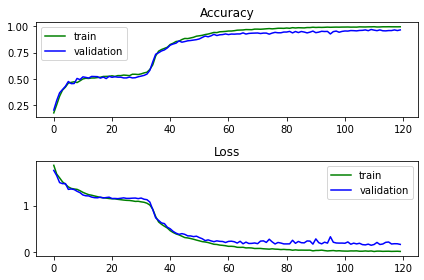

In [ ]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

테스트 데이터에 대해서 실제로 문제를 잘 맞히고 있는지 임의로 30개의 예측 결과를 출력해 볼게요.

In [ ]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
Where is John ?     : hallway  hallway
Where is Mary ?     : bathroom bathroom
Where is Sandra ?   : kitchen  kitchen
Where is Sandra ?   : hallway  hallway
Where is Sandra ?   : kitchen  kitchen
Where is Sandra ?   : hallway  hallway
Where is Sandra ?   : garden   garden
Where is Daniel ?   : hallway  hallway
Where is Sandra ?   : office   office
Where is Daniel ?   : office   office
Where is Mary ?     : kitchen  kitchen
Where is Mary ?     : garden   garden
Where is Daniel ?   : office   office
Where is Mary ?     : bedroom  bedroom
Where is Mary ?     : bedroom  kitchen
Where is John ?     : kitchen  kitchen
Where is John ?     : garden   garden
Where is John ?     : kitchen  kitchen
Where is Daniel ?   : office   bedroom
Where is John ?     : kitchen  kitchen
Where is Mary ?     : hallway  hallway
Where is John ?     : office   office
Where is John ?     : office   office
Where is Sandra ?   : hallway  hallwa

# 14-6. 프로젝트: 한국어 QA 모델 만들기
아래의 데이터셋은 bAbI 데이터셋을 저자가 한국어로 변환한 한국어 버전의 bAbI 데이터셋입니다.

데이터 다운로드(로컬 유저용)
[e-28-korean.zip ](https://aiffelstaticprd.blob.core.windows.net/media/documents/e-28-korean.zip)

압축을 해제해서 사용해주세요.

[데이터셋 소개]
데이터셋의 형태는 아래와 같이 영어 데이터셋과 동일합니다.
```
1 은경이는 복도로 가버렸습니다.
2 필웅이는 화장실로 뛰어갔습니다.
3 은경이는 어디야?     복도  1
4 수종이는 화장실로 복귀했습니다.
5 은경이는 침실로 갔습니다.
6 필웅이는 어디야?     화장실 2
7 은경이는 복도로 이동했습니다.
8 경임이는 부엌으로 뛰어갔습니다.
9 경임이는 어디야?     부엌  8
10 경임이는 복도로 가버렸습니다.
11 은경이는 정원으로 이동했습니다.
12 경임이는 어디야?     복도  10
13 경임이는 화장실로 복귀했습니다.
14 경임이는 부엌으로 갔습니다.
15 경임이는 어디야?     부엌  14
```

이번 프로젝트에서는 위 한국어 버전의 데이터셋에 대해서 동작하는 QA 모델을 만들어보겠습니다.

주의❗ 기존 케라스 공식 문서의 babi_rnn, babi_memn 구현은 파이썬 3.6을 기준으로 하고 있으며, 파이썬 3.7에서는 정상동작 하지 않을 수 있습니다. 실습 시 참고하세요!

## Step 1. 토크나이저 변경하기 (매우 중요!!!)
영어권 언어는 띄어쓰기만해도 단어들이 잘 분리되지만, 한국어는 그렇지 않다고 앞에서 몇 차례 언급했었죠? 한국어 데이터를 사용하여 모델을 구현하는 것만큼 이번에는 형태소 분석기를 사용해서 단어 토큰화를 해보겠습니다.

그런데 형태소 분석기를 사용할 때, 이런 상황에 봉착한다면 어떻게 해야할까요?

형태소 분석 입력 : '은경이는 사무실로 갔습니다.'
형태소 분석 결과 : ['은', '경이', '는', '사무실', '로', '갔습니다', '.']
사실 위 문장에서 '은경이'는 사람 이름이므로 제대로 된 결과를 얻기 위해서는 '은', '경이'와 같이 글자가 분리되는 것이 아니라 '은경이' 또는 최소한 '은경'이라는 단어 토큰을 얻어야만 합니다.

이런 경우에는 형태소 분석기에 사용자 사전을 추가해줄 수 있습니다.

'은경이'는 하나의 단어이기 때문에 분리하지말라고 형태소 분석기에 알려주는 것이죠.

사용자 사전을 추가하는 방법은 형태소 분석기마다 다소 다른데, 생각보다 복잡한 경우도 많습니다. 이번 실습에서는 Customized Konlpy라는 사용자 사전 추가가 매우 쉬운 패키지를 사용합니다.

Customized Konlpy 설치 방법
로컬유저용
설치 방법과 사용 방법에 대한 자세한 설명은 아래의 링크를 참고하세요!

[Customized Konlpy 사용하기](https://inspiringpeople.github.io/data%20analysis/ckonlpy/)


가령, 트위터라는 형태소 분석기를 사용한다고 하였을 때, '은경이'라는 단어를 사용자 사전에 추가하고 나서 문장을 형태소 분석하려면 어떻게 해야 할까요?



In [ ]:
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

ModuleNotFoundError: ignored

##Step 2. 형태소 분석 후 불용어 처리하기
------------
형태소 분석기로 문자를 분석해보면 '는', '으로' 등 분석에 크게 도움이 되지 않을 것 같은 토큰들이 나올 거에요. 처음에는 이 토큰들도 그대로 사용해서 모델을 구현해보고, 두 번째 구현에서는 이 토큰들을 전처리 과정에서 불용어 처리하여 제외해 봅시다.

##Step 3. 한국어에서의 모델 정확도 확인해보기
--------------
앞서 만든 메모리 네트워크는 영어권 데이터에서는 보편적으로 약 96% 이상의 높은 성능을 보입니다. 하이퍼파라미터를 잘 조정하면 이보다 더 높은 정확도가 나오기도 합니다. 그렇다면 메모리 네트워크가 한국어에서도 영어만큼 잘 동작할까요? 직접 확인해 봅시다.